# 10.03 День 1
(да, в этот раз начинаем почти в последний момент)

База данных клинвар: https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh37/clinvar.vcf.gz

(clinvar.vcf.gz)


```bash
bedtools intersect -a professor.vcf -b clinvar.vcf > intersected.vcf
```

intersected.vcf --> only clinically important variant

In [41]:
import subprocess
import re

import pandas as pd
from IPython.display import display

In [10]:
def proc_output(proc):
    if proc.stdout:
        print(proc.stdout.decode('utf-8'))
    if proc.stderr:
        print(proc.stderr.decode('utf-8'))

In [4]:
data_folder = './data/'

# 1. Конвертация в .vcf (и фильтровка только на снипы)

In [15]:
raw23andme = 'SNP_raw_v4_Full_20170514175358.txt'
vcf23andme = 'snps_clean'

proc = subprocess.run([
    './plink',
    '--23file', raw23andme, 
    '--output-chr', 'MT',
    '--recode', 'vcf',
    '--out', vcf23andme,
    '--snps-only', 'just-acgt',
], capture_output=True, cwd=data_folder)

proc_output(proc)

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to snps_clean.log.
Options in effect:
  --23file SNP_raw_v4_Full_20170514175358.txt
  --out snps_clean
  --output-chr MT
  --recode vcf
  --snps-only just-acgt

7809 MB RAM detected; reserving 3904 MB for main workspace.
--23file: snps_clean-temporary.bed + snps_clean-temporary.bim +
snps_clean-temporary.fam written.
15125 variants with indel calls present.  '--snps-only no-DI' or
--list-23-indels may be useful here.
Inferred sex: male.
595401 out of 610526 variants loaded from .bim file.
1 person (1 male, 0 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1 founder and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%2

# 2. Пересечения с БД

### 2.1 SnpSift annotate clinvar.vcf

```bash
java -jar SnpSift.jar annotate clinvar.vcf  snps_clean.vcf > snps_clean_snpsift_clinvar.vcf
```

```bash
# выбрать те, у которых есть что=-то про значимость
grep -i 'clnsig' snps_clean_snpsift_clinvar.vcf > snps_clean_snpsift_clinvar_clnsig.vcf
# отбросить доброкачественные
grep -v 'CLNSIG=Benign' snps_clean_snpsift_clinvar_clnsig.vcf > snps_clean_snpsift_clinvar_clinsig_notbenign.vcf

```

#### Факторы риска

In [129]:
rsid = re.compile('([rsi0-9]*;)')
diag = re.compile("CLNDN=[0-9a-zA-Z_|',''-]*;")

with open(data_folder + 'snps_clean_snpsift_clinvar_clnsig_risk_factors.vcf', 'r') as f:
    for line in f:
        print('***')
        
        print(re.search(diag, line).group(0))
        print(re.search(rsid, line).group(0))
        line = line.split('\t')
        print(line[3], line[4])
        # print(line[])
        
        
#         print(line[2], line[7])
#         print()
        # print(re.search(rsid, line))
        

***
CLNDN=Myocardial_infarction_1;
rs5174;
C T
***
CLNDN=Hyperlipidemia,_familial_combined,_susceptibility_to;
rs2073658;
C T
***
CLNDN=Atypical_hemolytic-uremic_syndrome_1;
rs460897;
C T
***
CLNDN=Asthma,_susceptibility_to;
i3000469;
C T
***
CLNDN=Diabetes_mellitus_type_2,_susceptibility_to;
rs4402960;
G T
***
CLNDN=Myocardial_infarction|Psoriatic_arthritis,_susceptibility_to;
rs909253;
A G
***
CLNDN=Diabetes_mellitus_type_2,_susceptibility_to|Diabetes_mellitus,_type_1,_susceptibility_to|Intracranial_hemorrhage_in_brain_cerebrovascular_malformations,_susceptibility_to|Rheumatoid_arthritis,_systemic_juvenile,_susceptibility_to|Kaposi_sarcoma,_susceptibility_to|Crohn_disease-associated_growth_failure,_susceptibility_to;
rs1800795;
C G
***
CLNDN=Bone_mineral_density_quantitative_trait_locus_15;
rs1801197;
A G
***
CLNDN=Rheumatoid_arthritis|Systemic_lupus_erythematosus_10;
rs2004640;
G T
***
CLNDN=Autism_15;
rs7794745;
A T
***
CLNDN=Diabetes_mellitus_type_2,_susceptibility_to;
rs13266634;

#### Патогенные

In [63]:
df = pd.read_csv(data_folder + "snps_clean_snpsift_clinvar_clnsig_notbenign.vcf", 
                 comment='#', sep='\t', header=None)


for i, row in df[df[7].apply(lambda x: 'pathogenic' in x)].iterrows():
    display(row)

0                                                    2
1                                             71829924
2                                        i5006568;6667
3                                                    A
4                                                    G
5                                                    .
6                                                    .
7    PR;AF_EXAC=0.00474;AF_TGP=0.00180;ALLELEID=217...
8                                                  NaN
9                                                  NaN
Name: 11, dtype: object

0                                                    2
1                                             74596527
2                                    rs17721059;259232
3                                                    C
4                                                    T
5                                                    .
6                                                    .
7    PR;AF_ESP=0.01376;AF_EXAC=0.01316;AF_TGP=0.007...
8                                                  NaN
9                                                  NaN
Name: 12, dtype: object

0                                                   12
1                                             57535266
2                                     rs1799986;930178
3                                                    C
4                                                    T
5                                                    .
6                                                    .
7    PR;ALLELEID=918498;CLNDISDB=Human_Phenotype_On...
8                                                   GT
9                                                  0/1
Name: 106, dtype: object

# 3. Гаплогруппы
https://dna.jameslick.com/mthap/mthap.cgi 

Best mtDNA Haplogroup Matches:

1) H(T152C)

Defining Markers for haplogroup H(T152C):
HVR2: 152C 263G
CR: 750G 1438G 4769G 8860G 15326G
HVR1:

Marker path from rCRS to haplogroup H(T152C):
H2a2a1(rCRS) ⇨ 263G ⇨ H2a2a ⇨ 8860G 15326G ⇨ H2a2 ⇨ 750G ⇨ H2a ⇨ 4769G ⇨ H2 ⇨ 1438G ⇨ H ⇨ 152C ⇨ H(T152C)

Imperfect Match. Your results contained differences with this haplogroup:
Matches(6): 152C 263G 750G 1438G 4769G 8860G
Untested(1): 15326

2) H1(T152C)

Defining Markers for haplogroup H1(T152C):
HVR2: 152C 263G
CR: 750G 1438G 3010A 4769G 8860G 15326G
HVR1:

Marker path from rCRS to haplogroup H1(T152C):
H2a2a1(rCRS) ⇨ 263G ⇨ H2a2a ⇨ 8860G 15326G ⇨ H2a2 ⇨ 750G ⇨ H2a ⇨ 4769G ⇨ H2 ⇨ 1438G ⇨ H ⇨ 3010A ⇨ H1 ⇨ 152C ⇨ H1(T152C)

Imperfect Match. Your results contained differences with this haplogroup:
Matches(6): 152C 263G 750G 1438G 4769G 8860G
No-Calls(1): 3010A
Untested(1): 15326

3) H

Defining Markers for haplogroup H:
HVR2: 263G
CR: 750G 1438G 4769G 8860G 15326G
HVR1:

Marker path from rCRS to haplogroup H (plus extra markers):
H2a2a1(rCRS) ⇨ 263G ⇨ H2a2a ⇨ 8860G 15326G ⇨ H2a2 ⇨ 750G ⇨ H2a ⇨ 4769G ⇨ H2 ⇨ 1438G ⇨ H ⇨ 152C

Imperfect Match. Your results contained differences with this haplogroup:
Matches(5): 263G 750G 1438G 4769G 8860G
Extras(1): 152C
Untested(1): 15326 

# 4. Y-Гаплогруппы


https://ytree.morleydna.com/predict

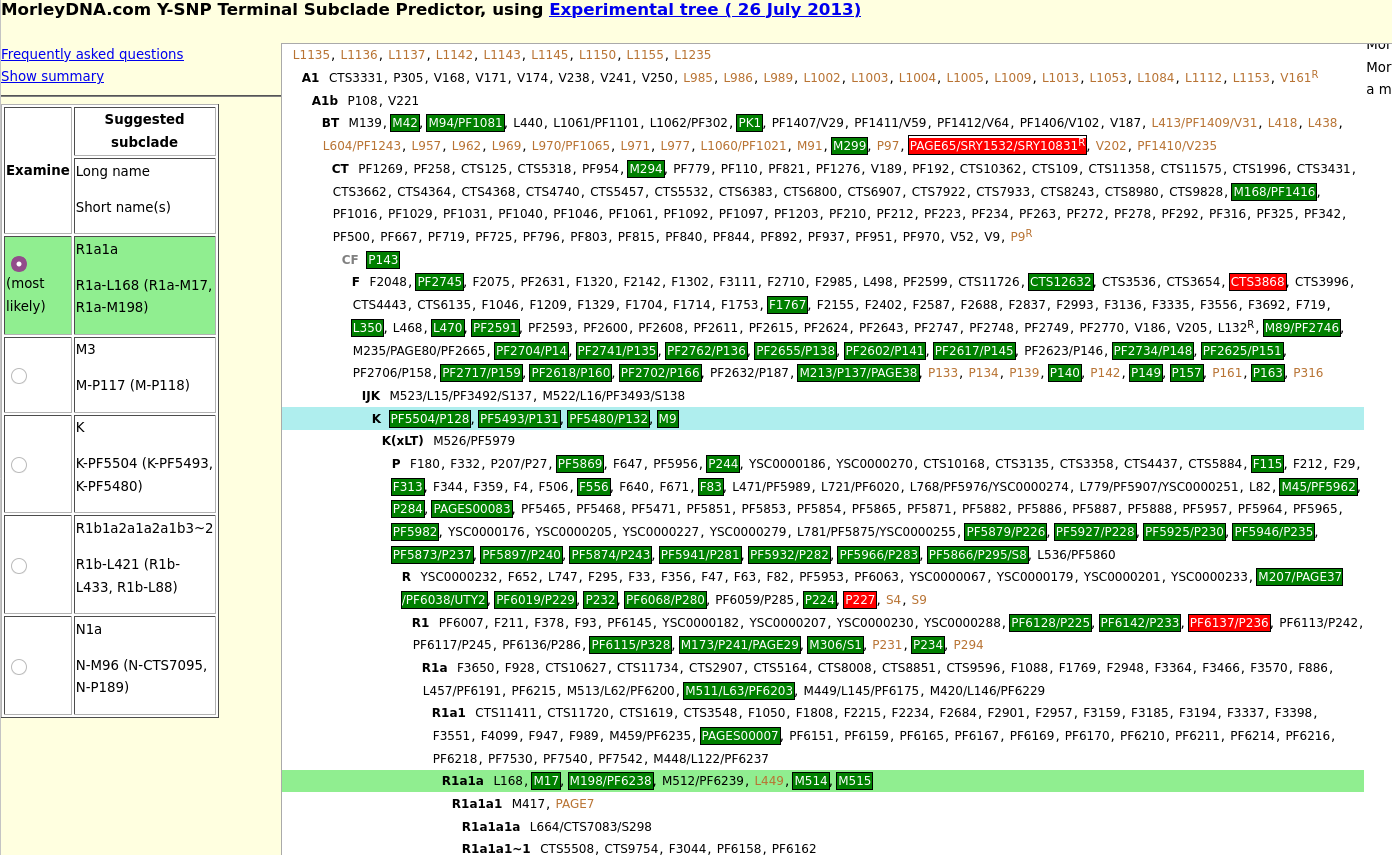

# 5. Ethnicity - PCA

# Поиск мутаций

```bash

grep 'rs121912617' snps_clean.vcf  # ничего нет
```
